# Introduction to Deep Learning on GPUs

Lab created by Jon Barker

The following timer counts down to a five minute warning before the lab instance shuts down.  You should get a pop up at the five minute warning reminding you to save your work!  If you are about to run out of time, please see the [Post-Lab](#Post-Lab-Summary) section for saving this lab to view offline later.

<iframe id="timer" src="timer/timer.html" width="100%" height="120px"></iframe>

---
Before we begin, let's verify [WebSockets](http://en.wikipedia.org/wiki/WebSocket) are working on your system.  To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Ctrl-Enter, or pressing the play button in the toolbar above.  If all goes well, you should see some output returned below the grey cell.  If not, please consult the [Self-paced Lab Troubleshooting FAQ](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) to debug the issue.

In [1]:
print "The answer should be three: " + str(1+2)

The answer should be three: 3


Let's execute the cell below to display information about the GPUs running on the server.

In [2]:
!nvidia-smi

Wed Jul 29 23:04:34 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 346.46     Driver Version: 346.46         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           On   | 0000:00:03.0     Off |                  N/A |
| N/A   51C    P0    43W / 125W |    282MiB /  4095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Introduction

In this class we will introduce the topic of Deep Learning, a rapidly growing segment of Artificial Intelligence.  Deep Learning is increasingly being used to deliver near-human level accuracy in image classification, voice recognition, natural language processing, and more.  In this class we will cover the basics of Deep Learning through some live examples, we will introduce the three major Deep Learning software frameworks and demonstrate why Deep Learning excels when run on GPUs.

This introductory class is intended to serve as a first introduction to the concept of Deep Learning and a live tour of the major software frameworks.  There is some complex looking code presented, but it is not necessary to understand this code to complete the class.  There are some times where you will be waiting a couple of minutes for the Deep Learning algorithms to run - feel free to use this time to explore the code.

By the end of this class you will hopefully be excited by the potential applications of Deep Learning and have a better idea of which of the frameworks you may want to learn more about in one of our [upcoming follow-on classes](https://developer.nvidia.com/deep-learning-courses).

## Demo

We will begin with a demonstration that will use a neural network to identify the subject of an image.  Click the button below to upload an image file from your local machine.  If you don't wish to upload an image just skip past this step and we'll randomly choose one of our images for you.

<iframe id="upload" src="upload" width="100%" height="200px"></iframe>

If you uploaded your own image, change the `your_image_name` to the new file name in the code below.  

To run or execute the cell, click in it and either press the play button in the toolbar at the top, or use Ctrl + Enter on your keyboard.  For this demo and for the rest of the lab, you will know the lab is processing when you see a solid circle in the top-right of the window that looks like this: ![](jupyter_executing.png)
Otherwise, when it is idle, you will see the following: ![](jupyter_idle.png)
For troubleshooting, please see [Self-paced Lab Troubleshooting FAQ](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) to debug the issue.

After executing the below cell, it will load the image into memory and display it for you.

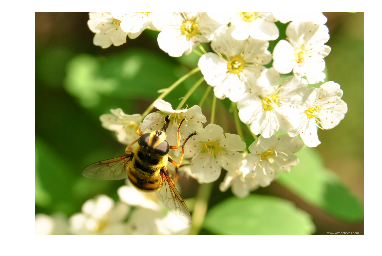

In [3]:
%matplotlib inline
import os

images_upload_dir = "/home/ubuntu/images/"
your_image_name = "bee.jpg"
image = images_upload_dir + your_image_name

import matplotlib.pyplot as plt
from PIL import Image
im = Image.open(image)
plt.imshow(im)
plt.axis('off')
plt.show()

Once the image is displayed above, execute the below cell to get some predictions about what the image is showing.

In [4]:
!/home/ubuntu/notebook/DLIntro/overfeat/bin/linux_64/cuda/overfeat_cuda -l -n 10 $image

bee 0.984789
fly 0.0145523
leaf beetle, chrysomelid 0.000292852
long-horned beetle, longicorn, longicorn beetle 0.000207962
ant, emmet, pismire 7.83908e-05
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle 3.20379e-05
honeycomb 1.2666e-05
lacewing, lacewing fly 1.04656e-05
cricket 6.43905e-06
cicada, cicala 4.62695e-06


What you see as output are 10 predictions (in order) about the contents of the image produced by a Deep Learning (DL) system called [Overfeat](http://cilvr.nyu.edu/doku.php?id=code:start). Each prediction is of an object which may be present in the image along with the confidence in the predictions.  In machine learning we call these predictions 'classifications'.

If you were tasked with writing a computer program to make predictions like this, how would you do it?

The traditional approach to this problem taken by the computer vision research community was to hand-craft functions which would look for particular features in the image that were believed to be indicative of certain objects or scenes.  For example, hard corners and straight edges might be believed to indicate the presence of manmade objects in the scene.  The responses from these feature extraction functions would then be fed into another function which would decide whether to declare a particular object had been detected in the image.

![Traditional approach](https://github.com/hack1nt0/Introduction-to-Deep-Learning/raw/master/files/DLIntro/tradition.png)

<div align="center">*Figure 1: Traditional approach to machine perception - hand-crafted features are extracted from the raw data and is then independently passed to a classification function. This typically leads to brittle and false-alarm prone detectors.*</div>

Unfortunately there are a number of problems with this approach.  Firstly, it is very hard to think of robust, reliable features which map to specific object types.  Secondly, it is a massive task to come up with the right combination of features for every type of object you want to be able to classify.  Thirdly, it is very difficult to design functions that are robust to translations, rotations and scalings of objects in the image.  Together these problems resulted in traditional computer vision struggling to develop high accuracy object detectors and classifiers for a broad range of objects.

The DL system that you saw demonstrated above was created in a very different way.  No human knowledge was encoded in the DL model about the types and combinations of features that are important for labelling different types of object or scene.  Instead, a combined feature extraction and classification model was learned by allowing the computer to examine millions of ground-truth labelled images to discover which features and combinations of features were most discriminative for each of the object classes (In machine learning we call this 'training' the model).  Furthermore, this was done in such a way that the model didn't just learn to classify the specific objects it was trained on; instead, it abstracted out the essence of those objects in such a way that it could recognize previously unseen but visually similar objects.  This learning process refined tens of millions of free parameters in the DL model above to be able to accurately classify 1000 different object types.  On a traditional CPU based server this training would take weeks to complete.  This network was instead trained in just hours by exploiting GPU acceleration.  Almost all DL systems today exploit massive GPU acceleration to make training practical.

![Machine learning approach](https://github.com/hack1nt0/Introduction-to-Deep-Learning/raw/master/files/DLIntro/DL.png)

<div align="center">*Figure 2: In the Deep Learning approach the feature extraction and classification functions are simultaneously learned using large amounts of training data.  The learned model can then be deployed in a new workflow where previously unseen data samples are classified.*</div>

In this class we are going to take a tour of the technology behind DL and the popular open-source frameworks which make it accessible to researchers and software developers today.  Hopefully by the end of the class you will have an appreciation for the varied applications of DL, the benefits of some of the available DL frameworks and the essential nature of GPU acceleration for training real-world networks in reasonable timeframes.

## What is Deep Learning?

Deep Learning (DL) is a branch of artificial intelligence research that is attempting to develop the techniques that will allow computers to learn complex perception tasks such as seeing and hearing at human levels of performance.  Recent advances in DL have yielded startling performance gains in fields such as computer vision, speech recognition and natural language understanding.  DL is already in use today to understand data and user inputs in technologies such as virtual personal assistants and online image search.  DL is an active area of ongoing research where it is envisaged that human level perception of unstructured data will enable technologies such as self-driving cars and truly intelligent machines.

DL attempts to use large volumes of unstructured data, such as images and audio clips, to learn hierarchical models which capture the complex structure in the data and then use these models to predict properties of previously unseen data.  For example, DL has proven extremely successful at learning hierarchical models of the visual features and concepts represented in handheld camera images and then using those models to automatically label previously unseen images with the objects present in them.

The models learned through DL are biologically inspired artificial neural networks (ANNs).  An ANN is an interconnected group of nodes, akin to the vast network of neurons in a brain. In the image below, each circular node represents an artificial neuron and an arrow represents a connection from the output of one neuron to the input of another.  Input data is fed into the red nodes, and dependent on the weights on the connections between nodes, causes varying levels of activation of the subsequent hidden and output nodes.  In our example above the input nodes would be connected to image pixels and the output nodes would have a one-to-one correspondence with the possible object classes; the job of the hidden nodes is to learn the complex function which maps pixels to object labels. 

![ANN](https://github.com/hack1nt0/Introduction-to-Deep-Learning/raw/master/files/DLIntro/ANN.png)

<div align="center">*Figure 3:  Fully-connected Artificial Neural Network with one hidden layer*</div>

For the advanced reader, the activation of a neuron is just a function of a variable which is the weighted sum of the inputs.  For basic neural networks the function is a sigmoid function.  The idea is that if the weighted sum of the inputs exceeds a threshold value, the neuron gives a positive output.

For ANNs to be effective in difficult perception tasks, such as object labelling in images, these networks usually have many stacked layers of artificial neurons each with many neurons in the layer.  It is these many wide layers that lead to these networks being labelled Deep Neural Networks (DNNs).  

One particular class of DNN which has shown great capability in visual perception tasks is called the Convolutional Neural Network (CNN).  CNNs have a structure which loosely resembles the structure the human visual cortex where lower levels of the model hierarchy are focused on small and local visual details, such as oriented line segments, which aggregate together into higher levels of the model which correspond to complex human concepts, such as faces and animals.

![CNN](https://github.com/hack1nt0/Introduction-to-Deep-Learning/raw/master/files/DLIntro/cnn.png)

<div align="center">*Figure 4:  Deep Neural Networks learn a hierarchical model of the input data in which the layers correspond to increasingly complex real-world concepts.  The number of parameters in a network is a function of the number of neurons in the network and the architecture of the network connectivity.*</div>

The [Imagenet Challenge](http://image-net.org/challenges/LSVRC/2014/index) is an annual competition where competitors are provided with 1.2 million natural images from the internet which are labelled with the objects that appear in those images using 1000 different class labels.  Competitors must create a model using this data which will then be tested against a further 100,000 images to see how accurately the model can identify and localize objects within them.  Over the past few years CNN based approaches have come to dominate the competition with accuracy in the object identification task recently exceeding 95% - which is comparable with human performance in labelling the objects in the test dataset.

The mathematics that underpins DL training is predominantly linear matrix algebra.  Computation of this type of mathematics is highly parallelizable making it a perfect fit for acceleration using GPUs.  Training a DNN that can be competitive in the Imagenet challenge is computationally very intensive and would take weeks, months or even years of computation on a CPU based system.  Through massive parallelization, GPUs can reduce this training time to days or even hours. Now almost all entrants into the Imagenet Challenge use GPUs, sometimes many of them, to train CNNs with billions of trainable parameters.  The graph below shows how significant recent improvements in accuracy in the Imagenet challenge correlate with the explosion in the use of GPUs for training DNN entries.

![](https://github.com/hack1nt0/Introduction-to-Deep-Learning/raw/master/files/DLIntro/gpuimagenet.png)

<div align="center">*Figure 5: The introduction of GPU accelerated Deep Learning into the ImageNet challenge began a period of unprecedented performance improvements.*</div>

GPUs are not only far more computationally efficient for training DNNs - they are also far more cost effective at scale.  In 2013 Google built it's "Google Brain" - a 1000 server, 16,000 core CPU based cluster for training a state-of-the-art DNN for image understanding.  It cost an estimated \$5,000,000 to build.  Shortly afterwards a team from the Stanford AI Lab showed that using 3 GPU accelerated servers with 12 GPUs per server - a total of 18,432 cores - they could train the same DNN and achieve the same performance.  Their system cost approximately $33,000 - 150th of the hardware cost and energy usage ([Wired Article](http://www.wired.com/2013/06/andrew_ng/)).

![Google Brain vs. Stanford GPUs](files/DLIntro/gbrain.png)

<div align="center">*Figure 6: GPUs are the most cost effective and size and power efficient means for training large Deep Neural Networks.*</div>

## Deep Learning Frameworks

In recent years a number of software development frameworks have been created to make researching and applying DL more accessible and efficient.  In this class we will introduce three of the current most popular frameworks: Caffe, Theano and Torch.  They all share the common benefits of providing highly optimized GPU enabled code specific to the computations required for training DNNs whilst providing access to that code through simple command line or scripting language interfaces such as Python.  Many powerful DNNs can be trained and deployed using these frameworks without ever having to write any GPU or complex compiled code but whilst still benefiting from the huge training speed-up afforded by GPU acceleration.

In order to compare and contrast these frameworks we will look at how you train a CNN in each of the frameworks to automatically classify images of different types.

### Framework 1: Caffe

[Caffe](http://caffe.berkeleyvision.org/) is a DL framework created by PhD student Yangqing Jia from UC Berkley.  Some of benefits of Caffe to the DL practitioner and researcher:
* Caffe is fast due to it's highly optimized C/CUDA backend which integrates GPU acceleration
* Caffe is still very accessible due to command line, Python and Matlab interfaces  
* The wrapper interfaces make it very easy to integrate DNN training and deployment into larger data analytics workflows  
* Caffe has a large open-source development community adding new features all time
* Caffe has an associated model-zoo where researchers can upload trained models for others to fine tune or use for inference using their own data

You may choose to use Caffe as your DL framework if you fit the following profile:

* You are interested in quickly getting up and running training and testing DNNs against your own image datasets without writing a lot of new code
* You are a C/CUDA developer wishing to extend DL functionality within a framework

One of the key benefits of Caffe for those wishing to apply deep learning to their own data is that defining and building many different types of DNN is possible without ever writing a line of code.  In this section we'll guide you through doing just that.

#### Caffe example

We're going to work with the well-known [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60000 32x32 color images split into ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.  Here are some examples:

![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png)![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile10.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/bird7.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/cat9.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/deer6.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/horse6.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/ship1.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/truck5.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/bird1.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/cat1.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/deer8.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/dog10.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/ship7.png) ![](http://www.cs.toronto.edu/~kriz/cifar-10-sample/horse4.png)

We're working with the smaller CIFAR-10 dataset so that you can actually train a network from start to finish within the time available in this class; however, the CNN we're defining and training exhibits all the essential features of the much larger networks used in the ImageNet challenge.

Training a DNN in Caffe requires you to provide three things: a [network definition file](files/caffe/examples/cifar10/cifar10_quick.prototxt) specifying the neural network architecture, a [solver definition file](files/caffe/examples/cifar10/cifar10_quick_solver.prototxt) specifying the training parameters and a dataset.  We've prepared each of these for you and there's no need to change them but you can take a look at them using the links provided.  The network and solver definition files are human readable text files.  Our dataset of images has been preloaded into a database to make it faster to read into Caffe.  

In the network definition file we specify the inputs, outputs and structure of each of the layers in the DNN.  Here is an example of how a convolutional layer is defined, which is representative of how all layers are defined:

The solver definition file is simply a list of parameters which are passed to the DNN training algorithm.  Here is how the parameters are set in this example:

The training process consists of first randomly initializing the weights on the connections between neurons in the network whose structure is defined in the network definition file.  Then, one at a time, each image in the training dataset is fed into the network along with its label.  The network guesses the label based purely on the input pixels - this is called classification.  If the guess is wrong then a small modification is made to the weights so that the network will guess more accurately for that image next time it sees it.  This process is repeated many thousands of times until the network converges to a stable average classification accuracy across all the training images.

Training the model is as simple as running the cell below.  When you do so, you will see a large number of messages flying by.  First the network will be initialized layer by layer and then training will begin.  After each 100 training iterations you will get an update on the training loss which should be decreasing and after each 500 you will get an update on the accuracy against a test set (Test net output #0) which should be increasing.  An iteration is when the network trains on each image in the training set exactly once.  **Training the network takes a couple of minutes**, so spend the time familiarizing yourself with Caffe's output - keep scrolling to the bottom of the output window to see the latest updates.

In [5]:
!cd /home/ubuntu/caffe && ./build/tools/caffe train --solver=examples/cifar10/cifar10_quick_solver.prototxt

libdc1394 error: Failed to initialize libdc1394
I0729 23:17:48.119890  6307 caffe.cpp:99] Use GPU with device ID 0
I0729 23:17:48.272471  6307 caffe.cpp:107] Starting Optimization
I0729 23:17:48.272606  6307 solver.cpp:32] Initializing solver from parameters: 
test_iter: 100
test_interval: 500
base_lr: 0.001
display: 100
max_iter: 4000
lr_policy: "fixed"
momentum: 0.9
weight_decay: 0.004
snapshot: 4000
snapshot_prefix: "examples/cifar10/cifar10_quick"
solver_mode: GPU
net: "examples/cifar10/cifar10_quick_train_test.prototxt"
I0729 23:17:48.272686  6307 solver.cpp:70] Creating training net from net file: examples/cifar10/cifar10_quick_train_test.prototxt
I0729 23:17:48.273134  6307 net.cpp:253] The NetState phase (0) differed from the phase (1) specified by a rule in layer cifar
I0729 23:17:48.273170  6307 net.cpp:253] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0729 23:17:48.273291  6307 net.cpp:42] Initializing net from parameters: 
name: 

Congratulations - you just trained your first DNN!  After 4000 iterations you will see the accuracy against the test set was ~71% - not bad for a couple of minutes training!  Each iteration took less than 0.0002 seconds to train using the GPU.

The learned network weights get saved into a binary file called cifar10_quick_iter_4000.caffemodel

Classifying new images using the newly trained dataset is just as simple as training was - this time we will use Caffe's Python interface.  Activate the cell below as many times as you like to randomly choose an image from the test set and have it classified - there is no need to edit any of the code. Remember - the test set is images that were never used in training the network.

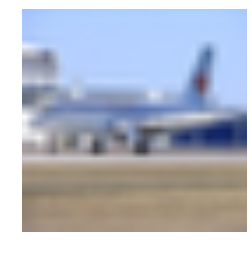

airplane


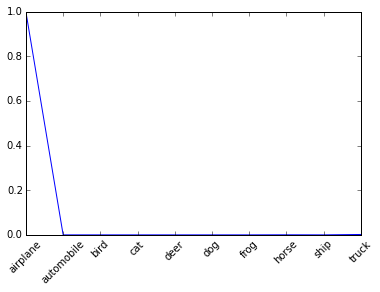

In [6]:
# Import required Python libraries
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import caffe
import random

# Choose network definition file and pretrained network binary
MODEL_FILE = '/home/ubuntu/caffe/examples/cifar10/cifar10_quick.prototxt'
PRETRAINED = '/home/ubuntu/caffe/examples/cifar10/cifar10_quick_iter_4000.caffemodel'

# Load a random image
x = caffe.io.load_image('/home/ubuntu/caffe/examples/images/' + str(random.randint(1,18)) + '.png')

# Display the chosen image
plt.imshow(x)
plt.axis('off')
plt.show()

# Load the pretrained model and select to use the GPU for computation
caffe.set_mode_gpu()
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load('/home/ubuntu/caffe/caffe/examples/cifar10/cifar10_mean.npy').mean(1).mean(1),
                       raw_scale=255,
                       image_dims=(32, 32))

# Run the image through the pretrained network
prediction = net.predict([x])

# List of class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display the predicted probability for each class
plt.plot(prediction[0])
plt.xticks(range(0,10), classes, rotation=45)
# Display the most probable class
print classes[prediction[0].argmax()]

Even for this relatively small dataset and network architecture GPU acceleration is still highly desirable.  Running the cell below will train the same network for 100 iterations using the CPU - as you will see, it is considerably slower than training on the GPU was above. Training for 0.025 times as many iterations takes about 50% more time!

In [ ]:
!cd /home/ubuntu/caffe && ./build/tools/caffe train --solver=examples/cifar10/cifar10_quick_solver_cpu.prototxt

Each training iteration this time took about 0.01 seconds - approximately fifty times slower.

### Framework 2: Theano

Theano is a Python DL library created at the University of Montreal.  Some benefits of Theano to the DL practioner and researcher are:
* Theano provides a highly expressive way of defining and training DNNs as it is built as a general symbolic math library and offers automatic function differentiation - this means the sky's the limit for DNN architectures and training methods that can be defined without leaving Python  
* Theano is still very fast due to a CUDA backend that enables GPU acceleration  
* Theano is tightly integrated with Python's popular NumPy library making integration into data analytics workflows a breeze.
* A number of lightweight Python libraries have been written on top of Theano to further simplify the DNN training process, e.g. [Lasagne](https://github.com/Lasagne/Lasagne) and [Keras](https://github.com/fchollet/keras)

You may choose to use Theano as your DL framework if you fit the following profile:
* You are a Python developer looking for a highly expressive DL framework
* You wish to develop a wider range of DL applications than just CNNs for imagery by defining new layer types, training algorithms and objective functions without leaving Python

#### Theano example

In this example we're going to work with the well know [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which consists of 28x28 pixel black and white images of handwritten digits.  Here are some examples:

![](http://deeplearning.net/tutorial/_images/mnist_0.png) ![](http://deeplearning.net/tutorial/_images/mnist_1.png) ![](http://deeplearning.net/tutorial/_images/mnist_2.png) ![](http://deeplearning.net/tutorial/_images/mnist_3.png) ![](http://deeplearning.net/tutorial/_images/mnist_4.png) ![](http://deeplearning.net/tutorial/_images/mnist_5.png) 

We start by importing some Python dependencies and then defining a Python class for Convolutional Layers with Max Pooling.  Don't worry too much about the details - we have included this here so you can see the symbolic math nature of Theano syntax.

**WARNING!** It is important that you execute each of the following cells in order as they build upon each other. It is suggested you execute the cells before parsing through the code - some of them can take a minute or two to run.  Remember to watch the circle in the top-right of the window - while it is solid the cell is still executing.

In [ ]:
import os
os.chdir('/home/ubuntu/notebook/DLIntro')
import sys
import timeit
import numpy
import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv
from logistic_sgd import LogisticRegression, load_data
from mlp import HiddenLayer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utils import tile_raster_images
from IPython import display

class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) /
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv.conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape
        )

        # downsample each feature map individually, using maxpooling
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

Next we define our CNN training parameters:

In [ ]:
learning_rate=0.1
dataset='/home/ubuntu/notebook/mnist.pkl.gz'
nkerns=[100, 50]
batch_size=128

We now run some pre-built scripts to load the MNIST dataset and compute how many training batches we will have given our chosen batch size:

In [ ]:
from logistic_sgd import load_data

rng = numpy.random.RandomState(23455)

datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches /= batch_size
n_valid_batches /= batch_size
n_test_batches /= batch_size

n_epochs=10000/n_train_batches

# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch
x = T.matrix('x')   # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels
    
print '... data loaded.'

Now we define our actual CNN layer-by-layer - again, spend as much time as like reviewing the code to understand Theano's syntax, but don't worry if you don't understand all the details.

In [ ]:
print '... building the model'

# Reshape matrix of rasterized images of shape (batch_size, 28 * 28)
# to a 4D tensor, compatible with our LeNetConvPoolLayer
# (28, 28) is the size of MNIST images.
layer0_input = x.reshape((batch_size, 1, 28, 28))

# Construct the first convolutional pooling layer:
# filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
# maxpooling reduces this further to (24/2, 24/2) = (12, 12)
# 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
layer0 = LeNetConvPoolLayer(
    rng,
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 25, 25),
    poolsize=(2, 2)
)

# Construct the second convolutional pooling layer
# filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
# maxpooling reduces this further to (8/2, 8/2) = (4, 4)
# 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
#layer1 = LeNetConvPoolLayer(
#    rng,
#    input=layer0.output,
#    image_shape=(batch_size, nkerns[0], 9, 9),
#    filter_shape=(nkerns[1], nkerns[0], 4, 4),
#    poolsize=(2, 2)
#)

# the HiddenLayer being fully-connected, it operates on 2D matrices of
# shape (batch_size, num_pixels) (i.e matrix of rasterized images).
# This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
# or (500, 50 * 4 * 4) = (500, 800) with the default values.
layer2_input = layer0.output.flatten(2)

# construct a fully-connected sigmoidal layer
layer2 = HiddenLayer(
    rng,
    input=layer2_input,
    n_in=nkerns[0] * 2 * 2,
    n_out=50,
    activation=T.tanh
)

# classify the values of the fully-connected sigmoidal layer
layer3 = LogisticRegression(input=layer2.output, n_in=50, n_out=10)

# the cost we minimize during training is the NLL of the model
cost = layer3.negative_log_likelihood(y)

# create a function to compute the mistakes that are made by the model
test_model = theano.function(
    [index],
    layer3.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    layer3.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

# create a list of all model parameters to be fit by gradient descent
params = layer3.params + layer2.params + layer0.params

# create a list of gradients for all model parameters
grads = T.grad(cost, params)

# train_model is a function that updates the model parameters by
# SGD Since this model has many parameters, it would be tedious to
# manually create an update rule for each model parameter. We thus
# create the updates list by automatically looping over all
# (params[i], grads[i]) pairs.
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)
print '... model built'

Now we can actually train the CNN. After each iteration you will see an updated visualization of the learned feature layers in the network - this will allow you to see what the network is learning to look for to differentiate the digit classes.  Note that the training cost displayed during training is not easily interpretable in terms of the actual network performance, but as a relative measure you should see it decreasing as the networks learns.  After executing this cell, scroll down to see the training in action!

In [ ]:
###############
# TRAIN MODEL #
###############
%matplotlib inline
print '... training'
# early-stopping parameters
patience = 10000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is
                           # found
improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):

        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print 'training @ iter = ', iter
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                    in xrange(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                    (epoch, minibatch_index + 1, n_train_batches,
                    this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:

                #improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss *  \
                    improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter

                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in xrange(n_test_batches)
                ]
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                        'best model %f %%') %
                        (epoch, minibatch_index + 1, n_train_batches,
                        test_score * 100.))
                
    display.clear_output()
    plt.imshow(tile_raster_images(
    X = layer0.W.get_value(borrow=True),
    img_shape=(25,25),
    tile_shape=(10,10),
    tile_spacing=(1,1)), 
    cmap= cm.Greys_r,
    aspect='auto')
    plt.axis('off')
    plt.title('Layer 0 convolutional filters, training cost: ' + str(test_score * 100))
    plt.show()
    plt.imshow(layer2.W.get_value(borrow=True)[:,:].T, 
    cmap= cm.Greys_r)
    plt.axis('off')
    plt.title('Layer 1 fully connected weights, training cost: ' + str(test_score * 100))   
    plt.show()
    plt.imshow(layer3.W.get_value(borrow=True)[:,:].T, 
    cmap= cm.Greys_r)
    plt.axis('off')
    plt.title('Layer 2 fully connected weights, training cost: ' + str(test_score * 100))   
    plt.show()

    if patience <= iter:
        done_looping = True
        break

end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, '
        'with test performance %f %%' %
        ((1 - best_validation_loss) * 100., best_iter + 1, (1 - test_score) * 100.))

You will see that after 10000 training iterations the classification accuracy against the test set is over 98%.  You may have noticed during training that the convolutional filters came to much more closely resemble line segments that make up the hand written digits and the layer 2 connection weights became more polarized suggesting that the network was learning specific grouping of filters which were significant for each of the digits.

You can read much more about this example and others in the excellent tutorials created by the Theano developers available [here](http://deeplearning.net/tutorial/). 

### Framework 3: Torch


Torch is a scientific computing framework based on the programming language Lua but with a highly optimized C/CUDA backend.  Torch is maintained by a group of research scientists from Facebook, Twitter and Google but also has an community of contributors to the open-source project.

Benefits of of Torch:
* Efficient Tensor library (like NumPy) with an efficient CUDA backend which lends itself well to DNN computations
* Dedicated Neural Networks package -- build arbitrary acyclic computation graphs with automatic differentiation
also with fast CUDA and CPU backends
* Good community and industry support - several hundred community-built and maintained packages - active contribution from web scale companies, e.g. Facebook
* Easy to use Multi-GPU support and distribution of neural network training

The Lua scripting language is fast due to Just In Time (JIT) compilation and is a lot like Javascript in syntax.

You may choose to use Torch as your DL framework if you fit the following profile:
* You are very concerned about run-time speed, but still want the convenience of a scripting interface
* You wish to use multiple GPUs for training

#### Torch example

DL is not only applicable to image data, there have been many recent successes applying DL to understanding natural language text.    One important class of DNNs for natural language understanding is called Recurrent Neural Networks (RNNs).  RNNs extend the standard multi-layer DNN with a temporal memory component that means the network can learn sequential patterns in input data.  This works by having the hidden layers in the network receive both a new data sample as well as their state at the previous time step as input at each iteration. This means that RNNs can learn functions such as time-series forecasting, music generation, natural language word sequences and character level text sequence prediction.  In the example below you see an RNN receiving the sequence "Hello world!" as training input in three character windows with a stride of three characters.

![RNN](https://github.com/hack1nt0/Introduction-to-Deep-Learning/raw/master/files/DLIntro/rnn.png)

<div align="center">*Figure 7:  Recurrent Neural Networks introduce a self-connection to the hidden nodes; this allows the network to remember it's previous states and subsequently learn significant predictive patterns in the input data.*</div> 

In this example we will show that an RNN built in Torch and trained on a variety of corpora of different styles of text is able to learn to generate random character sequence that retain the appropriate style, vocabulary, punctuation and formatting.  Given a large volume of training text (between 1.1 and 6.2 million training characters per model) the model learns to predict the next character in a partial character sequence; this means the model can generate original text conforming to the same style as the text it has been trained on.

Training the RNN capable of generating this style appropriate text takes about an hour per text corpus on an NVIDIA GRID K520 GPU running Torch.  Training the same network on a CPU would take about 100 times as long.  We have already done that GPU training for you. We made use of the excellent [code](https://github.com/karpathy/char-rnn) written by Andrej Karpathy of Google. We highly recommend reading Andrej's fascinating blog post associated with this code describing [The Unreasonable Effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).  

Edit the style variable in the cell below to choose a trained network and then run it to see the Torch based RNN randomly generate text in one of the following styles:  William Shakespeare, Leo Tolstoy, President Barack Obama's speech writers or the Linux kernal source code authors.  You can also try increasing the `-length` input to get more text, but it will take longer to generate.

**NOTE** If you try the `linux` style, the output will be randomly generated text (character by character) that looks like kernel source code. This is not an error!

In [ ]:
%%bash
style='tolstoy'  # Choose from: tinyshakespeare, tolstoy, obama, linux
cd /home/ubuntu/notebook/DLIntro/char-rnn/
th sample.lua checkpoints/$style/checkpoint.t7 -gpuid 0 -length 500 -primetext ' '

Remember there was nothing changed in the structure of the RNN to learn each of these different styles except for the data that was use for training.  This generated text is entirely random (and meaningless) in the specific words chosen and it is not generate from complete sentences sampled from the original input; rather it is a sequence of characters generated one at a time, which makes it astonishing that it conforms to style so well.

## DIGITS

DIGITS is a **D**eep Learning **G**PU **T**raining **S**ystem developed by NVIDIA to help researchers and analysts to easily develop, train and test CNNs.  DIGITS is also a visualization tool that enables real-time visualization of important metrics during CNN training.  DIGITS uses the Caffe framework which we saw above for CNN training.

The DIGITS dashboard lets researchers manage their training datasets and training of DNNs.  It also makes it easy to explore and test what your DNN has learned.

Most recently in DIGITS 2, DIGITS can manage multiple GPUs in a single machine and distribute training of a single DNN across those GPUs for significant training speed increases.

![](https://github.com/hack1nt0/Introduction-to-Deep-Learning/raw/master/files/DLIntro/digits_dashboard.png)

<div align="center">*Figure 8:  Interface to the NVIDIA DIGITS Deep Learning tool.*</div>

DIGITS is a great place to get started learning more about Deep Learning and the practicalities of training DNNs.  There is a webinar and associated Qwiklab focused on DIGITS coming soon.  Register [here](https://developer.nvidia.com/deep-learning-courses).

## More information

To learn more about these topics, please visit:
* GPU accelerated machine learning: [http://www.nvidia.com/object/machine-learning.html](http://www.nvidia.com/object/machine-learning.html)
* Caffe: [http://caffe.berkeleyvision.org/](http://caffe.berkeleyvision.org/)
* Theano: [http://deeplearning.net/software/theano/](http://deeplearning.net/software/theano/)
* Torch: [http://torch.ch/](http://torch.ch/)
* DIGITS: [https://developer.nvidia.com/digits](https://developer.nvidia.com/digits)
* cuDNN: [https://developer.nvidia.com/cudnn](https://developer.nvidia.com/cudnn)

## Post-Lab Summary

If you would like to download this lab for later viewing, it is recommend you go to your browsers File menu (not the Jupyter notebook file menu) and save the complete web page.  This will ensure the images are copied down as well.

### Deep Learning Lab Series

Make sure to check out the rest of the classes in this Deep Learning lab series.  You can find them [here](https://developer.nvidia.com/deep-learning-courses).

## Summary

In this class we have shown that there are a variety of exciting applications of DL that are accesible today through the open-source frameworks Caffe, Theano and Torch.  Each of these frameworks has their own unique advantages and are better suited to different types of user and application.  Hopefully this tour has given you some insight into which frameworks may best suit your research or development needs.  In the coming weeks we will be releasing more classes which dive deeper into the specific workings of each of these frameworks.